# Task 3 - Transfer Learning
Team Members

*   Libin Kutty
*   Viju Sudhi
*   Ritu Gahir

In [ ]:
%tensorflow_version 2.x

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

# 3.1 - Same Distribution

**Source label 0-6**
**Target label 7-9**

In [15]:
train , test =tf.keras.datasets.mnist.load_data()

In [19]:
train_x , train_y = train
test_x, test_y = test

In [2]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
np.unique(train_lbls)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
target = [7, 8, 9]
source_img = []
source_lbl = []
target_img = []
target_lbl = []

for img, lbl in zip(train_imgs, train_lbls):
  if lbl in target:

    if lbl == 7:
      img_lbl = 0
    elif lbl == 8:
      img_lbl = 1
    elif lbl == 9:
      img_lbl = 2

    target_img.append(img)
    target_lbl.append(img_lbl)
  else:
    source_img.append(img)
    source_lbl.append(lbl)

for img, lbl in zip(test_imgs, test_lbls):
  if lbl in target:

    if lbl == 7:
      img_lbl = 0
    elif lbl == 8:
      img_lbl = 1
    elif lbl == 9:
      img_lbl = 2

    target_img.append(img)
    target_lbl.append(img_lbl)
  else:
    source_img.append(img)
    source_lbl.append(lbl)

source_img = np.array(source_img)
source_lbl = np.array(source_lbl)
target_img = np.array(target_img)
target_lbl = np.array(target_lbl)

In [ ]:
train_src_imgs, test_src_imgs, train_src_lbls, test_src_lbls = train_test_split(source_img, source_lbl, test_size=0.33)
train_tar_imgs, test_tar_imgs, train_tar_lbls, test_tar_lbls = train_test_split(target_img, target_lbl, test_size=0.33)

In [ ]:
train_tar_lbls

array([2, 2, 2, ..., 2, 2, 1])

In [ ]:
train_src_imgs = (train_src_imgs.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
train_src_lbls = train_src_lbls.astype(np.int32)
#train_src_lbls = to_categorical(train_src_lbls)

test_src_imgs = (test_src_imgs.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
test_src_lbls = test_src_lbls.astype(np.int32)

In [ ]:
batch_size = 128

train_data_src = tf.data.Dataset.from_tensor_slices((train_src_imgs, train_src_lbls))

train_data_src = train_data_src.shuffle(train_src_imgs.shape[0])
train_data_src = train_data_src.batch(batch_size)
train_data_src = train_data_src.repeat(5)


test_data_src = tf.data.Dataset.from_tensor_slices((test_src_imgs, test_src_lbls))
test_data_src = test_data_src.batch(batch_size)

Model with 7 unit in output layer

In [ ]:
def model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(7))
  model.add(Activation('softmax'))

  return model

Model with 3 unit in output layer

In [ ]:
def model_w3():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(3))
  model.add(Activation('softmax'))

  return model

In [ ]:
def train(model, train_data):
  step_graph = []
  loss_graph = []
  acc_graph = []
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  opt = tf.optimizers.Adam()

  for step, (img_batch, lbl_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
        logits = model(img_batch)
        xent = loss_fn(lbl_batch, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)

    opt.apply_gradients(zip(grads, varis))
    
    train_acc_metric(lbl_batch, logits)
    
    if not step % 50:
      step_graph.append(step)
      loss_graph.append(xent)
      acc_graph.append(train_acc_metric.result())
      print("Loss: {} Accuracy: {}".format(xent, train_acc_metric.result()))
      train_acc_metric.reset_states()
  
  return step_graph, loss_graph, acc_graph

In [ ]:
def test(model, test_data):
  test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
  loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
  for img_batch, lbl_batch in test_data:
    logits = model(img_batch)
    xent = loss_fn(lbl_batch, logits) 
    test_acc_metric(lbl_batch, logits)

  print(test_acc_metric.result())
  return test_acc_metric.result()

Training the source dataset

In [ ]:
source_model = model()

step_src, loss_src, acc_src = train(source_model, train_data_src)

Loss: 1.9463082551956177 Accuracy: 0.1171875
Loss: 1.2604228258132935 Accuracy: 0.7204687595367432
Loss: 1.2068250179290771 Accuracy: 0.942187488079071
Loss: 1.2135868072509766 Accuracy: 0.9603124856948853
Loss: 1.2178782224655151 Accuracy: 0.9635937213897705
Loss: 1.1838932037353516 Accuracy: 0.9701562523841858
Loss: 1.18574857711792 Accuracy: 0.9681680798530579
Loss: 1.198087215423584 Accuracy: 0.9753124713897705
Loss: 1.1884393692016602 Accuracy: 0.9762499928474426
Loss: 1.1942236423492432 Accuracy: 0.9779687523841858
Loss: 1.199697732925415 Accuracy: 0.9790624976158142
Loss: 1.1675631999969482 Accuracy: 0.9804233908653259
Loss: 1.1775022745132446 Accuracy: 0.9800000190734863
Loss: 1.199669599533081 Accuracy: 0.9800000190734863
Loss: 1.1778579950332642 Accuracy: 0.9826562404632568
Loss: 1.188737392425537 Accuracy: 0.9818750023841858
Loss: 1.1898553371429443 Accuracy: 0.9820149540901184
Loss: 1.1712349653244019 Accuracy: 0.9854687452316284
Loss: 1.1718021631240845 Accuracy: 0.9878125

In [ ]:
test_src_acc = test(source_model, test_data_src)

tf.Tensor(0.98655933, shape=(), dtype=float32)


In [ ]:
source_model.layers[-3].output

<tf.Tensor 'dense/BiasAdd:0' shape=(None, 64) dtype=float32>

Replacing the final layer

In [ ]:
def target_model(src_model):
  model = src_model.layers[-3].output #src_model.input #Sequential()
  #for layer in src_model.layers[:-2]: 
  #  model = layer(model) 
  #model = Dense(3, activation = "softmax")(model)
  predictions = Dense(3, activation = "softmax")(model)
  tar_model = tf.keras.Model(inputs = src_model.input, outputs = predictions)

  return tar_model

In [ ]:
train_tar_imgs = (train_tar_imgs.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
train_tar_lbls = train_tar_lbls.astype(np.int32)

test_tar_imgs = (test_tar_imgs.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
test_tar_lbls = test_tar_lbls.astype(np.int32)

In [ ]:
batch_size = 128

train_data_tar = tf.data.Dataset.from_tensor_slices((train_tar_imgs, train_tar_lbls))

train_data_tar = train_data_tar.shuffle(train_tar_imgs.shape[0])
train_data_tar = train_data_tar.batch(batch_size)
train_data_tar = train_data_tar.repeat(5)


test_data_tar = tf.data.Dataset.from_tensor_slices((test_tar_imgs, test_tar_lbls))
test_data_tar = test_data_tar.batch(batch_size)

In [ ]:
tar_model = target_model(source_model)

In [ ]:
tar_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)         

In [ ]:
source_model.weights[0][0][0]

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.1059945 ,  0.11258342,  0.06337678,  0.03553294,  0.02902536,
         0.05787674,  0.18449849,  0.13577473, -0.08018813, -0.27843082,
         0.09958471, -0.08533765,  0.16296718, -0.15561816, -0.29013747,
         0.00424468,  0.10158167,  0.02678826,  0.01167544,  0.13529679,
        -0.03815495, -0.01806433, -0.01937757,  0.16696051, -0.00445585,
         0.10150947,  0.16305792, -0.1606787 , -0.22973023,  0.0032112 ,
         0.00986402,  0.17425962]], dtype=float32)>

In [ ]:
tar_model.weights[0][0][0]

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 0.1059945 ,  0.11258342,  0.06337678,  0.03553294,  0.02902536,
         0.05787674,  0.18449849,  0.13577473, -0.08018813, -0.27843082,
         0.09958471, -0.08533765,  0.16296718, -0.15561816, -0.29013747,
         0.00424468,  0.10158167,  0.02678826,  0.01167544,  0.13529679,
        -0.03815495, -0.01806433, -0.01937757,  0.16696051, -0.00445585,
         0.10150947,  0.16305792, -0.1606787 , -0.22973023,  0.0032112 ,
         0.00986402,  0.17425962]], dtype=float32)>

Training the target dataset

In [ ]:
step_tar, loss_tar, acc_tar = train(tar_model, train_data_tar)

Loss: 1.1767442226409912 Accuracy: 0.3671875
Loss: 0.910397469997406 Accuracy: 0.6068750023841858
Loss: 0.9355337023735046 Accuracy: 0.6646875143051147
Loss: 0.892554521560669 Accuracy: 0.6563687920570374
Loss: 0.8332664370536804 Accuracy: 0.6735937595367432
Loss: 0.8610647320747375 Accuracy: 0.6633396744728088
Loss: 0.5620189905166626 Accuracy: 0.905468761920929
Loss: 0.5698987245559692 Accuracy: 0.983998715877533
Loss: 0.5855183005332947 Accuracy: 0.9876562356948853
Loss: 0.5580063462257385 Accuracy: 0.9922370314598083
Loss: 0.5518978238105774 Accuracy: 0.9926562309265137
Loss: 0.5594223737716675 Accuracy: 0.9920312762260437


In [ ]:
test_tar_acc = test(tar_model, test_data_tar)

tf.Tensor(0.9941058, shape=(), dtype=float32)


Training the target dataset without transfer learning

In [ ]:
model_wo = model_w3()
step_wot, loss_wot, acc_wot = train(model_wo, train_data_tar)

Loss: 1.0935554504394531 Accuracy: 0.4921875
Loss: 0.5808792114257812 Accuracy: 0.8695312738418579
Loss: 0.5820715427398682 Accuracy: 0.9532812237739563
Loss: 0.5815043449401855 Accuracy: 0.9697401523590088
Loss: 0.5641752481460571 Accuracy: 0.9753124713897705
Loss: 0.5659958124160767 Accuracy: 0.9779784679412842
Loss: 0.5646950006484985 Accuracy: 0.9785937666893005
Loss: 0.5713980197906494 Accuracy: 0.9871672987937927
Loss: 0.5585107207298279 Accuracy: 0.9857812523841858
Loss: 0.5640503168106079 Accuracy: 0.9863751530647278
Loss: 0.5525838136672974 Accuracy: 0.9862499833106995
Loss: 0.5591676831245422 Accuracy: 0.9903125166893005


In [ ]:
test_tar_acc_wo = test(model_wo, test_data_tar)

tf.Tensor(0.9918056, shape=(), dtype=float32)


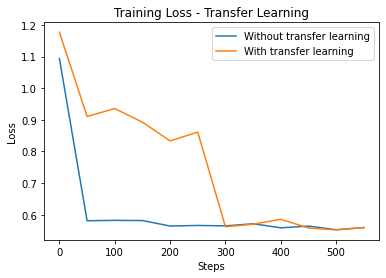

In [ ]:
plt.plot(step_wot, loss_wot, label="Without transfer learning")
plt.plot(step_tar, loss_tar, label="With transfer learning")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss - Transfer Learning')
plt.legend()
plt.show()

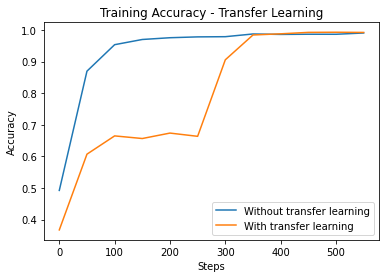

In [ ]:
plt.plot(step_wot, acc_wot, label="Without transfer learning")
plt.plot(step_tar, acc_tar, label="With transfer learning")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy - Transfer Learning')
plt.legend()
plt.show()

# 3.2 Different distribution

In [ ]:
def default_model():
  model = Sequential()

  model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(128, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  model.add(Dense(64))
  #model.add(Activation('relu'))

  model.add(Dense(10))
  model.add(Activation('softmax'))

  return model

MNIST Dataset

In [ ]:
(train_imgs_mnist, train_lbls_mnist), (test_imgs_mnist, test_lbls_mnist) = tf.keras.datasets.mnist.load_data()

train_imgs_mnist = (train_imgs_mnist.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
train_lbls_mnist = train_lbls_mnist.astype(np.int32)

test_imgs_mnist = (test_imgs_mnist.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
test_lbls_mnist = test_lbls_mnist.astype(np.int32)

batch_size = 128

train_data_mnist = tf.data.Dataset.from_tensor_slices((train_imgs_mnist, train_lbls_mnist))

train_data_mnist = train_data_mnist.shuffle(train_imgs_mnist.shape[0])
train_data_mnist = train_data_mnist.batch(batch_size)
train_data_mnist = train_data_mnist.repeat(5)


test_data_mnist = tf.data.Dataset.from_tensor_slices((test_imgs_mnist, test_lbls_mnist))
test_data_mnist = test_data_mnist.batch(batch_size)

Fashion MNIST Dataset

In [ ]:
(train_imgs_fsmnist, train_lbls_fsmnist), (test_imgs_fsmnist, test_lbls_fsmnist) = tf.keras.datasets.fashion_mnist.load_data()

train_imgs_fsmnist = (train_imgs_fsmnist.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
train_lbls_fsmnist = train_lbls_fsmnist.astype(np.int32)

test_imgs_fsmnist = (test_imgs_fsmnist.astype(np.float32) / 255.).reshape((-1, 28, 28, 1))
test_lbls_fsmnist = test_lbls_fsmnist.astype(np.int32)

batch_size = 128

train_data_fsmnist = tf.data.Dataset.from_tensor_slices((train_imgs_fsmnist, train_lbls_fsmnist))

train_data_fsmnist = train_data_fsmnist.shuffle(train_imgs_fsmnist.shape[0])
train_data_fsmnist = train_data_fsmnist.batch(batch_size)
train_data_fsmnist = train_data_fsmnist.repeat(5)


test_data_fsmnist = tf.data.Dataset.from_tensor_slices((test_imgs_fsmnist, test_lbls_fsmnist))
test_data_fsmnist = test_data_fsmnist.batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
train_lbls_fsmnist

array([9, 0, 0, ..., 3, 0, 5], dtype=int32)

MNIST Dataset as the source dataset

In [ ]:
mnist_model = default_model()

step_mn, loss_mn, acc_mn = train(mnist_model, train_data_mnist)

Loss: 2.3029680252075195 Accuracy: 0.0703125
Loss: 1.751751184463501 Accuracy: 0.4828124940395355
Loss: 1.569417953491211 Accuracy: 0.8557812571525574
Loss: 1.556774377822876 Accuracy: 0.9021875262260437
Loss: 1.549023151397705 Accuracy: 0.9273437261581421
Loss: 1.5348480939865112 Accuracy: 0.9307812452316284
Loss: 1.5261204242706299 Accuracy: 0.9490625262260437
Loss: 1.5124695301055908 Accuracy: 0.9440624713897705
Loss: 1.504996657371521 Accuracy: 0.9548437595367432
Loss: 1.493395447731018 Accuracy: 0.9518749713897705
Loss: 1.5367774963378906 Accuracy: 0.9586997628211975
Loss: 1.499949336051941 Accuracy: 0.9579687714576721
Loss: 1.506998062133789 Accuracy: 0.9553124904632568
Loss: 1.5068415403366089 Accuracy: 0.9620312452316284
Loss: 1.5025954246520996 Accuracy: 0.9673437476158142
Loss: 1.478967308998108 Accuracy: 0.9657812714576721
Loss: 1.4859415292739868 Accuracy: 0.9703124761581421
Loss: 1.4867292642593384 Accuracy: 0.96875
Loss: 1.5086967945098877 Accuracy: 0.9732812643051147
Los

In [ ]:
test_acc_mnist = test(mnist_model, test_data_mnist)

tf.Tensor(0.9846, shape=(), dtype=float32)


Training the Fashion MNIST dataset with transfer learning

In [ ]:
fs_mnist_model = mnist_model

step_fs, loss_fs, acc_fs = train(fs_mnist_model, train_data_fsmnist)

Loss: 2.3549206256866455 Accuracy: 0.0859375
Loss: 2.022902488708496 Accuracy: 0.3817187547683716
Loss: 1.9860600233078003 Accuracy: 0.4703125059604645
Loss: 1.9476890563964844 Accuracy: 0.4815624952316284
Loss: 1.8910539150238037 Accuracy: 0.5135937333106995
Loss: 1.8378387689590454 Accuracy: 0.5314062237739563
Loss: 1.9618291854858398 Accuracy: 0.5217187404632568
Loss: 1.8313511610031128 Accuracy: 0.5417187213897705
Loss: 1.7907609939575195 Accuracy: 0.6239062547683716
Loss: 1.8532145023345947 Accuracy: 0.6220312714576721
Loss: 1.8379943370819092 Accuracy: 0.6331658363342285
Loss: 1.8160619735717773 Accuracy: 0.6470312476158142
Loss: 1.878300428390503 Accuracy: 0.6434375047683716
Loss: 1.8140270709991455 Accuracy: 0.6421874761581421
Loss: 1.8226652145385742 Accuracy: 0.640625
Loss: 1.8511953353881836 Accuracy: 0.6381250023841858
Loss: 1.8278193473815918 Accuracy: 0.6382812261581421
Loss: 1.8012464046478271 Accuracy: 0.6371874809265137
Loss: 1.7980321645736694 Accuracy: 0.646562516689

Training the Fashion MNIST dataset without transfer learning

In [ ]:
fsmnist_wot_model = default_model()

step_fwot, loss_fwot, acc_fwot = train(fsmnist_wot_model, train_data_fsmnist)

Loss: 2.30465030670166 Accuracy: 0.0546875
Loss: 1.847964882850647 Accuracy: 0.44328126311302185
Loss: 1.884586215019226 Accuracy: 0.6342187523841858
Loss: 1.794710636138916 Accuracy: 0.6667187213897705
Loss: 1.8463695049285889 Accuracy: 0.6810937523841858
Loss: 1.760230541229248 Accuracy: 0.6915624737739563
Loss: 1.7802324295043945 Accuracy: 0.7132812738418579
Loss: 1.7569588422775269 Accuracy: 0.7001562714576721
Loss: 1.697756052017212 Accuracy: 0.7106249928474426
Loss: 1.7292402982711792 Accuracy: 0.7203124761581421
Loss: 1.788008451461792 Accuracy: 0.7129396796226501
Loss: 1.7085421085357666 Accuracy: 0.7260937690734863
Loss: 1.7046900987625122 Accuracy: 0.7292187213897705
Loss: 1.7304954528808594 Accuracy: 0.7454687356948853
Loss: 1.7807178497314453 Accuracy: 0.742968738079071
Loss: 1.7012666463851929 Accuracy: 0.7407812476158142
Loss: 1.7295808792114258 Accuracy: 0.7442187666893005
Loss: 1.7310975790023804 Accuracy: 0.7534375190734863
Loss: 1.68818998336792 Accuracy: 0.7568749785

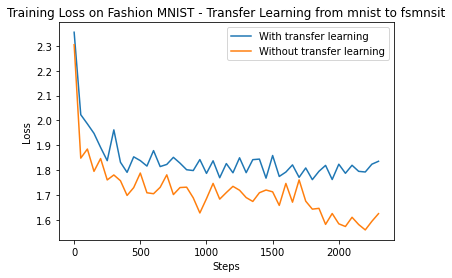

In [ ]:
plt.plot(step_fs, loss_fs, label="With transfer learning")
plt.plot(step_fwot, loss_fwot, label="Without transfer learning")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss on Fashion MNIST - Transfer Learning from mnist to fsmnsit')
plt.legend()
plt.show()

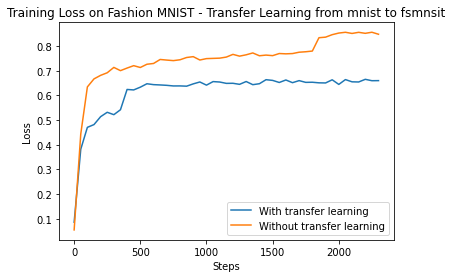

In [ ]:
plt.plot(step_fs, acc_fs, label="With transfer learning")
plt.plot(step_fwot, acc_fwot, label="Without transfer learning")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss on Fashion MNIST - Transfer Learning from mnist to fsmnsit')
plt.legend()
plt.show()

Fashion MNIST as the source dataset

In [ ]:
fsmnist_m = default_model()

step_fmnsit, loss_fmnsit, acc_fmnist = train(fsmnist_m, train_data_fsmnist)

Loss: 2.303196430206299 Accuracy: 0.0625
Loss: 1.886330246925354 Accuracy: 0.4231249988079071
Loss: 1.8317818641662598 Accuracy: 0.5824999809265137
Loss: 1.9498096704483032 Accuracy: 0.596875011920929
Loss: 1.8234096765518188 Accuracy: 0.6032812595367432
Loss: 1.803544044494629 Accuracy: 0.6303125023841858
Loss: 1.8551366329193115 Accuracy: 0.6357812285423279
Loss: 1.8289556503295898 Accuracy: 0.6337500214576721
Loss: 1.7835421562194824 Accuracy: 0.6556249856948853
Loss: 1.7228612899780273 Accuracy: 0.65234375
Loss: 1.7975759506225586 Accuracy: 0.6648869514465332
Loss: 1.7804182767868042 Accuracy: 0.667187511920929
Loss: 1.7528753280639648 Accuracy: 0.6779687404632568
Loss: 1.8054485321044922 Accuracy: 0.7045312523841858
Loss: 1.6786333322525024 Accuracy: 0.7642187476158142
Loss: 1.6591261625289917 Accuracy: 0.7620312571525574
Loss: 1.7190595865249634 Accuracy: 0.7620312571525574
Loss: 1.7046499252319336 Accuracy: 0.7640625238418579
Loss: 1.6991961002349854 Accuracy: 0.7668750286102295

MNIST as target dataset

In [ ]:
mnist_m = fsmnist_m

step_mnsit_tl, loss_mnsit_tl, acc_mnist_tl = train(mnist_m, train_data_mnist)

Loss: 2.291486978530884 Accuracy: 0.171875
Loss: 2.0590550899505615 Accuracy: 0.27796876430511475
Loss: 1.9436876773834229 Accuracy: 0.45140624046325684
Loss: 1.9032399654388428 Accuracy: 0.5126562714576721
Loss: 1.861138105392456 Accuracy: 0.5764062404632568
Loss: 1.8955321311950684 Accuracy: 0.5776562690734863
Loss: 1.8508213758468628 Accuracy: 0.5778124928474426
Loss: 1.878696084022522 Accuracy: 0.5803124904632568
Loss: 1.8952019214630127 Accuracy: 0.5882812738418579
Loss: 1.9228568077087402 Accuracy: 0.582812488079071
Loss: 1.8167697191238403 Accuracy: 0.5924937129020691
Loss: 1.7588070631027222 Accuracy: 0.6365625262260437
Loss: 1.6691393852233887 Accuracy: 0.7265625
Loss: 1.709134578704834 Accuracy: 0.7678124904632568
Loss: 1.6253033876419067 Accuracy: 0.8520312309265137
Loss: 1.6258432865142822 Accuracy: 0.860156238079071
Loss: 1.5829899311065674 Accuracy: 0.8668749928474426
Loss: 1.6219508647918701 Accuracy: 0.8754687309265137
Loss: 1.5927088260650635 Accuracy: 0.87640625238418

MNIST without transfer learning

In [ ]:
mnist_wot_model = default_model()

step_mwot, loss_mwot, acc_mwot = train(mnist_wot_model, train_data_mnist)

Loss: 2.3018674850463867 Accuracy: 0.1171875
Loss: 1.769319772720337 Accuracy: 0.49140626192092896
Loss: 1.7807843685150146 Accuracy: 0.6495312452316284
Loss: 1.725900650024414 Accuracy: 0.6714062690734863
Loss: 1.6915481090545654 Accuracy: 0.7568749785423279
Loss: 1.709367275238037 Accuracy: 0.7593749761581421
Loss: 1.5981857776641846 Accuracy: 0.8360937237739563
Loss: 1.60121750831604 Accuracy: 0.8515625
Loss: 1.5854380130767822 Accuracy: 0.8621875047683716
Loss: 1.6046252250671387 Accuracy: 0.8693749904632568
Loss: 1.5759062767028809 Accuracy: 0.8596105575561523
Loss: 1.568199872970581 Accuracy: 0.883593738079071
Loss: 1.504042387008667 Accuracy: 0.9515625238418579
Loss: 1.4902960062026978 Accuracy: 0.957812488079071
Loss: 1.488509178161621 Accuracy: 0.9653124809265137
Loss: 1.5229030847549438 Accuracy: 0.95703125
Loss: 1.5070281028747559 Accuracy: 0.9660937786102295
Loss: 1.4830081462860107 Accuracy: 0.9660937786102295
Loss: 1.5259714126586914 Accuracy: 0.9667187333106995
Loss: 1.5

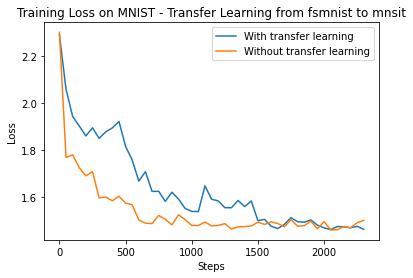

In [ ]:
plt.plot(step_mnsit_tl, loss_mnsit_tl, label="With transfer learning")
plt.plot(step_mwot, loss_mwot, label="Without transfer learning")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss on MNIST - Transfer Learning from fsmnist to mnsit')
plt.legend()
plt.show()

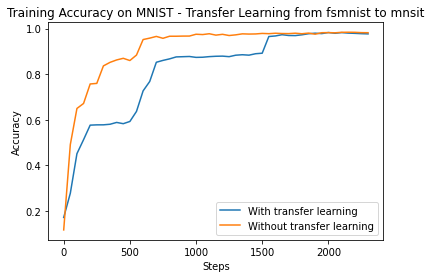

In [ ]:
plt.plot(step_mnsit_tl, acc_mnist_tl, label="With transfer learning")
plt.plot(step_mwot, acc_mwot, label="Without transfer learning")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy on MNIST - Transfer Learning from fsmnist to mnsit')
plt.legend()
plt.show()

# 3.3 Compare diffferent ways to do the transfer learning

Keeping Fashion MNIST as the Source dataset and MNIST as Target dataset

In [ ]:
model1 = default_model()

step1, loss1, acc1 = train(model1, train_data_fsmnist)

Loss: 2.3027710914611816 Accuracy: 0.1015625
Loss: 1.9355524778366089 Accuracy: 0.43843749165534973
Loss: 1.7457538843154907 Accuracy: 0.6743749976158142
Loss: 1.7239166498184204 Accuracy: 0.7107812762260437
Loss: 1.7097705602645874 Accuracy: 0.7365624904632568
Loss: 1.7604111433029175 Accuracy: 0.7520312666893005
Loss: 1.739973783493042 Accuracy: 0.76171875
Loss: 1.7740534543991089 Accuracy: 0.7717187404632568
Loss: 1.7545669078826904 Accuracy: 0.7592187523841858
Loss: 1.6339126825332642 Accuracy: 0.7670312523841858
Loss: 1.6968107223510742 Accuracy: 0.7804648280143738
Loss: 1.7129573822021484 Accuracy: 0.780468761920929
Loss: 1.7062666416168213 Accuracy: 0.7835937738418579
Loss: 1.6748504638671875 Accuracy: 0.7795312404632568
Loss: 1.6734559535980225 Accuracy: 0.7878124713897705
Loss: 1.586578369140625 Accuracy: 0.7909374833106995
Loss: 1.6570929288864136 Accuracy: 0.7979687452316284
Loss: 1.7025609016418457 Accuracy: 0.7928125262260437
Loss: 1.6812403202056885 Accuracy: 0.7857812643

Setting trainable for all the pretrained layer as False except the last layer

In [ ]:
def set_trainable_model(src_model):
  model = src_model
  for layer in model.layers[:-3]: 
    layer.trainable = False 
  return model

In [ ]:
model2 = set_trainable_model(model1)

step2, loss2, acc2 = train(model2, train_data_mnist)

Loss: 2.37777042388916 Accuracy: 0.078125
Loss: 2.2463502883911133 Accuracy: 0.13781249523162842
Loss: 2.228031635284424 Accuracy: 0.18687500059604645
Loss: 2.257002353668213 Accuracy: 0.21250000596046448
Loss: 2.1836817264556885 Accuracy: 0.22499999403953552
Loss: 2.2073428630828857 Accuracy: 0.27796876430511475
Loss: 2.104985237121582 Accuracy: 0.3214062452316284
Loss: 2.1904914379119873 Accuracy: 0.31468749046325684
Loss: 2.1095848083496094 Accuracy: 0.33531248569488525
Loss: 2.074343204498291 Accuracy: 0.34281250834465027
Loss: 2.080660581588745 Accuracy: 0.35615578293800354
Loss: 2.0166049003601074 Accuracy: 0.4129687547683716
Loss: 2.01625919342041 Accuracy: 0.42656248807907104
Loss: 1.9200711250305176 Accuracy: 0.44843751192092896
Loss: 2.064894437789917 Accuracy: 0.4373437464237213
Loss: 2.088120698928833 Accuracy: 0.4426562488079071
Loss: 1.97408127784729 Accuracy: 0.45390623807907104
Loss: 2.0015101432800293 Accuracy: 0.44437500834465027
Loss: 2.0047497749328613 Accuracy: 0.4

In [ ]:
model1.layers[-3:]

Setting trainable as False for bottom layers

In [ ]:
model3 = model1
for layer in model3.layers[-3:]: 
  layer.trainable = False 

step3, loss3, acc3 = train(model3, train_data_mnist)

Loss: 1.8687372207641602 Accuracy: 0.59375
Loss: 1.929485559463501 Accuracy: 0.5478125214576721
Loss: 1.939746379852295 Accuracy: 0.5526562333106995
Loss: 1.8024518489837646 Accuracy: 0.534375011920929
Loss: 1.8985599279403687 Accuracy: 0.5435937643051147
Loss: 1.8447144031524658 Accuracy: 0.5623437762260437
Loss: 1.9097903966903687 Accuracy: 0.546875
Loss: 1.90534508228302 Accuracy: 0.5418750047683716
Loss: 1.9419361352920532 Accuracy: 0.5562499761581421
Loss: 1.8289804458618164 Accuracy: 0.5543749928474426
Loss: 1.9037123918533325 Accuracy: 0.5538630485534668
Loss: 1.88058602809906 Accuracy: 0.5501562356948853
Loss: 1.8558225631713867 Accuracy: 0.5550000071525574
Loss: 1.928299903869629 Accuracy: 0.5489062666893005
Loss: 1.8922736644744873 Accuracy: 0.55078125
Loss: 1.8980984687805176 Accuracy: 0.5535937547683716
Loss: 1.7774078845977783 Accuracy: 0.5487499833106995
Loss: 1.8413565158843994 Accuracy: 0.54296875
Loss: 1.9157530069351196 Accuracy: 0.5457812547683716
Loss: 1.87030625343

In [ ]:
model1.layers[-4]

Replacing top layers

*Tried replacing top layer but it didnt work. I am not sure what I am doing wrong

In [ ]:
#model4 = Sequential()

input_layer = tf.keras.Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_layer) #, input_shape=(28, 28, 1)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

for layer in model1.layers[-4:]: 
  x = layer(x)

model4 = tf.keras.models.Model(inputs = input_layer, outputs = x)

In [ ]:
step4, loss4, acc4 = train(model4, train_data_mnist)

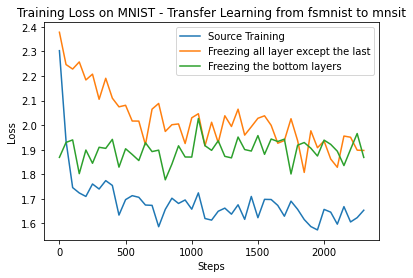

In [ ]:
plt.plot(step1, loss1, label="Source Training")
plt.plot(step2, loss2, label="Freezing all layer except the last")
plt.plot(step3, loss3, label="Freezing the bottom layers")

plt.xlabel('Steps')
plt.ylabel('Loss')

plt.title('Training Loss on MNIST - Transfer Learning from fsmnist to mnsit')
plt.legend()
plt.show()

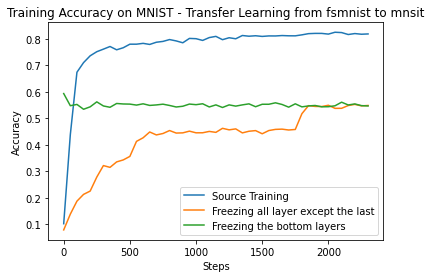

In [ ]:
plt.plot(step1, acc1, label="Source Training")
plt.plot(step2, acc2, label="Freezing all layer except the last")
plt.plot(step3, acc3, label="Freezing the bottom layers")

plt.xlabel('Steps')
plt.ylabel('Accuracy')

plt.title('Training Accuracy on MNIST - Transfer Learning from fsmnist to mnsit')
plt.legend()
plt.show()

# Conclusion
---

*   During same distribution, it can be observed that for the target distribution, with the help of transfer learning it reached 99% faster than without transfer learning
*   Durring different distribution, keeping source mnist didnt help much with training of fsmnist but it helped little when fsmnist was kept has source
*   Freezing the bottom layer helped better during transfer learning

